paper https://epubs.siam.org/doi/pdf/10.1137/1.9781611976236.13

paper code https://github.com/zghafoori/Deep-Multi-Sphere-SVDD/tree/670ba3c7604347d249758b49f1865c51616c6a3c

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pandas as pd
from seaborn import boxplot
import random
from torch.optim.lr_scheduler import MultiStepLR

from utils import *
from networks import *
from centroids import *
from batchscores import *
from epochscores import *

In [3]:
nbr_epochs = 250 # paper says 150 + 100
batch_size = 512 # paper says 200
# dataset = 'MNIST'
dataset = 'FashionMNIST'
# dataset = 'CIFAR10'
normal_cls = [0,1,2]
nbr_centroids = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4
nu = 0.1 # best of 3 values indicated in paper
use_pretraining = False # paper says True

In [4]:
nbr_seeds = 3 # how many different random init to try
valid_AUCs = torch.zeros((nbr_seeds, nbr_epochs+1))
test_AUCs = torch.zeros((nbr_seeds, nbr_epochs+1))
losses = torch.zeros((nbr_seeds, nbr_epochs))
losses_radius_sqmean = torch.zeros((nbr_seeds, nbr_epochs))
losses_margin_loss = torch.zeros((nbr_seeds, nbr_epochs))
nbr_centroids_evolution = torch.zeros((nbr_seeds, nbr_epochs))

cf. https://github.com/zghafoori/Deep-Multi-Sphere-SVDD/blob/670ba3c7604347d249758b49f1865c51616c6a3c/src/opt/sgd/train.py#L12 and https://github.com/zghafoori/Deep-Multi-Sphere-SVDD/blob/670ba3c7604347d249758b49f1865c51616c6a3c/src/opt/sgd/train.py#L283

/home/blupon/anaconda3/envs/recent/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630797748/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
100%|██████████| 250/250 [04:30<00:00,  1.08s/it]


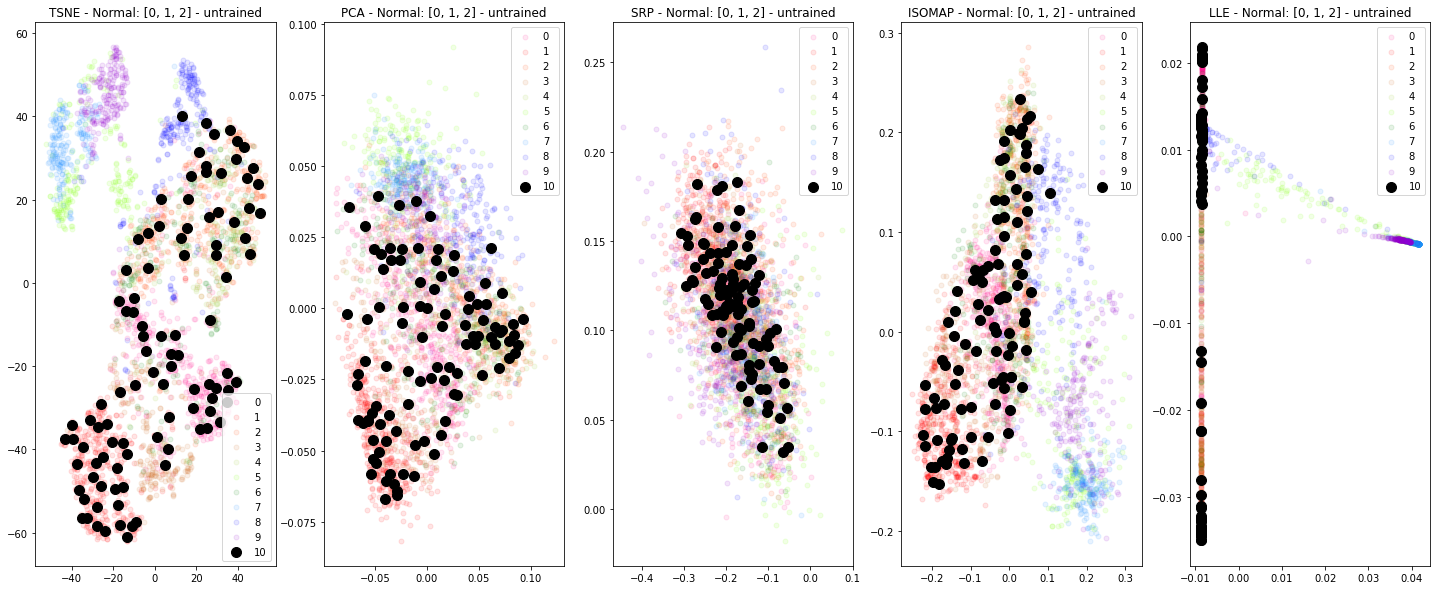

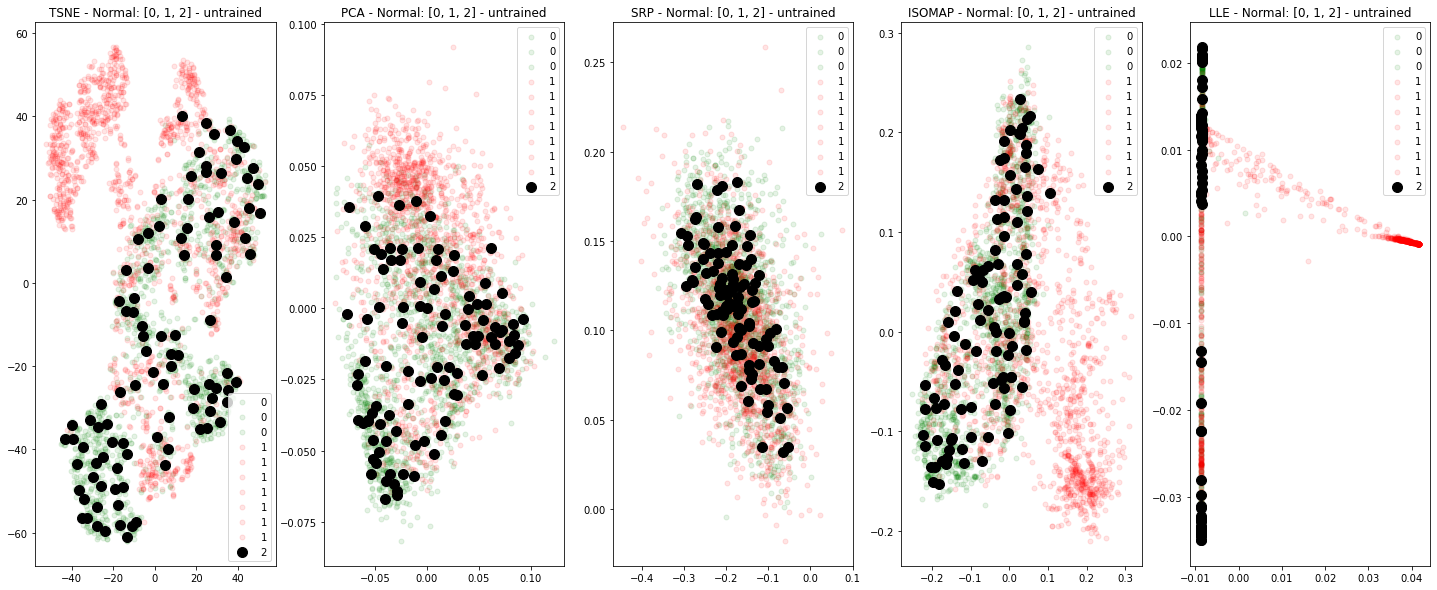

100%|██████████| 250/250 [03:53<00:00,  1.07it/s]


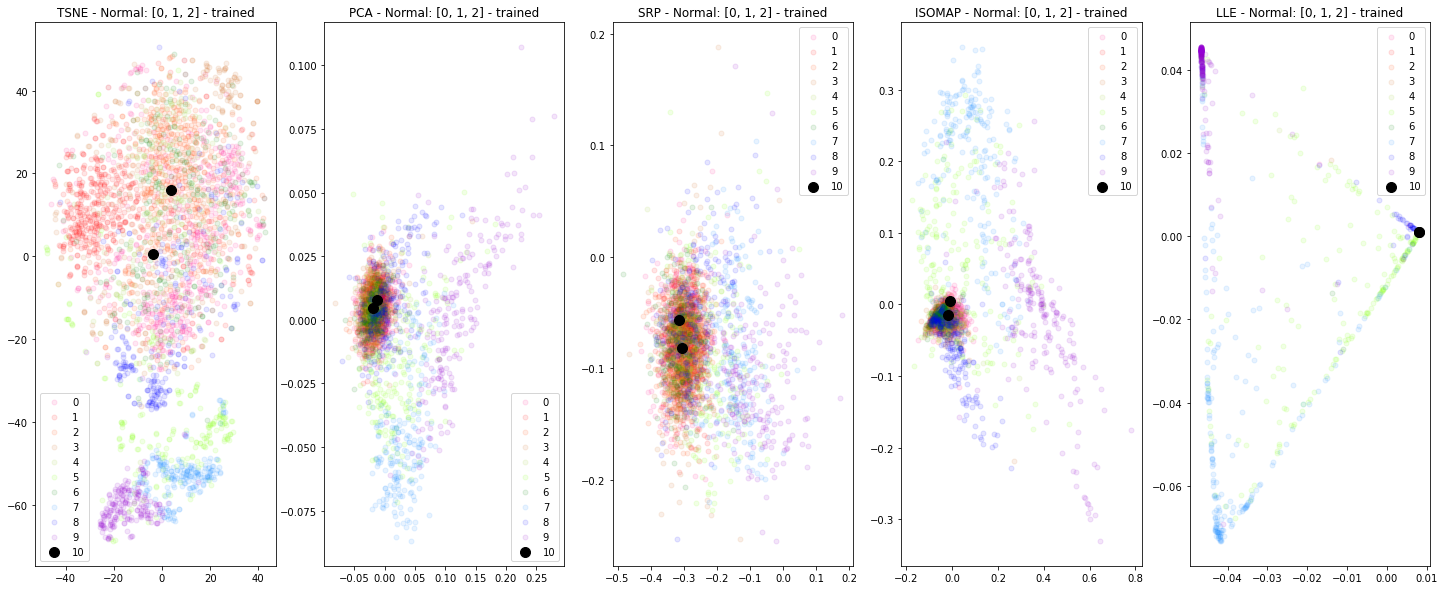

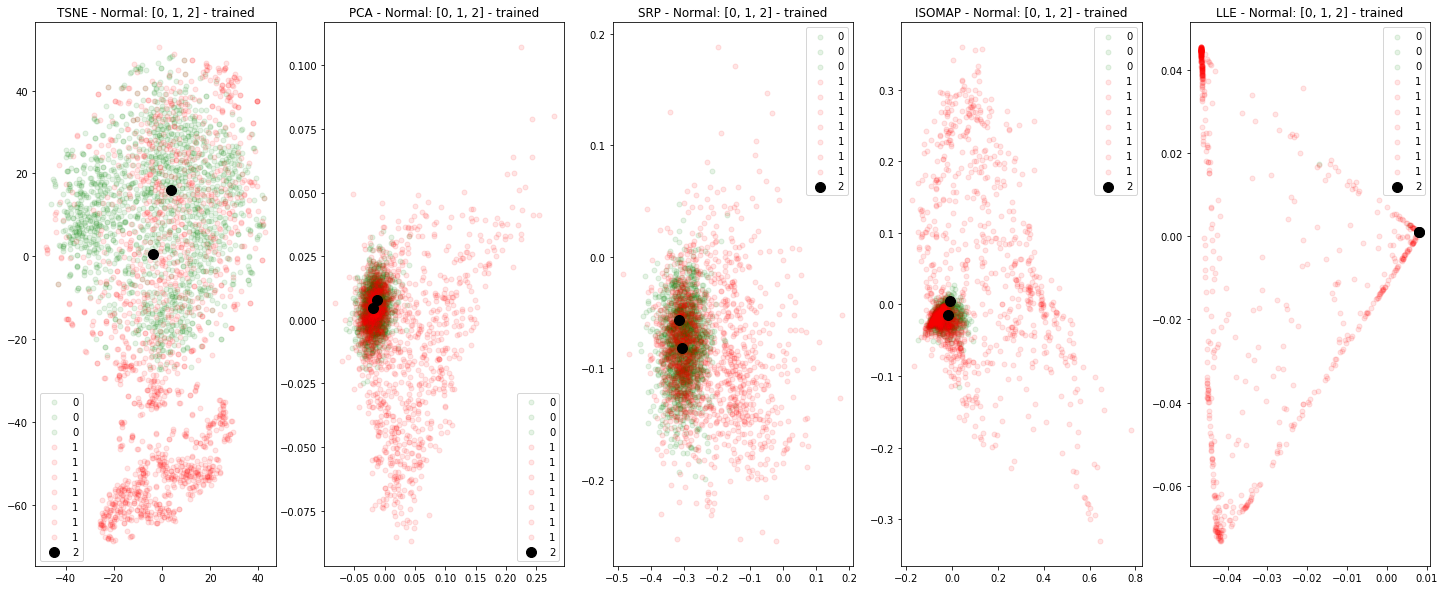

In [5]:
for seed_idx in range(nbr_seeds):
    
    torch.manual_seed(seed_idx)
    random.seed(seed_idx)
    np.random.seed(seed_idx)
    
    train_loader, valid_loader, test_loader, x_train, y_train, _, _, _, _ = get_dataloaders_MNIST_FashionMNIST(batch_size, normal_cls, dataset, seed=seed_idx)
    if dataset == 'MNIST':
        net = MNIST_LeNet().to(device)
    elif dataset == 'FashionMNIST':
        net = FashionMNIST_LeNet().to(device)
    else:
        net = CIFAR10_LeNet().to(device)
    if use_pretraining:
        net = init_network_weights_from_pretraining(net, dataset, normal_cls, seed_idx)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
    scheduler = MultiStepLR(optimizer, milestones=[150], gamma=0.1)
    pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    hyperspheres_center, _ = init_centers_c_kmeans_MSVDD(device, x_train, y_train, net, nbr_centroids=nbr_centroids, batch_size=batch_size, seed=seed_idx)

    # plot latent distribution before and after training only for last seed in order not to flood the notebook with graphs
    if seed_idx == nbr_seeds-1:
        plot_distribution(test_loader, net, hyperspheres_center, device, "untrained", normal_cls)
    
    for epoch in tqdm(range(nbr_epochs), position=0, leave=True):
        
        radius = update_radius_DMSVDD(hyperspheres_center, nu, train_loader, net, device)
        valid_AUCs[seed_idx,0],test_AUCs[seed_idx,epoch], _, _, _ = get_epoch_performances_DMSVDD(valid_loader, test_loader, device, net, hyperspheres_center, radius, normal_cls)
        
        net.train()
        running_loss = 0.0
        running_loss_radius_sqmean = 0.0
        running_loss_margin_loss = 0.0

        for i, (data,targets) in enumerate(train_loader, 0):
            inputs, labels = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            dist_to_centers = torch.sum((outputs.unsqueeze(1).repeat(1,hyperspheres_center.size()[0],1) - hyperspheres_center.unsqueeze(0).repeat(outputs.size()[0],1,1)) ** 2, dim=2)
            dist_to_best_center, best_center_idx = torch.min(dist_to_centers, dim=1)
            best_center_sqradius = radius[best_center_idx] ** 2
            
            radius_sqmean = (1 / radius.size()[0]) * torch.sum(radius**2)
            margin_loss = (1 / (nu*inputs.size()[0])) * torch.sum(torch.maximum(dist_to_best_center-best_center_sqradius,torch.zeros((dist_to_best_center.size()[0],)).to(device)))
            
            loss = radius_sqmean + margin_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_loss_radius_sqmean += radius_sqmean.item()
            running_loss_margin_loss += margin_loss.item()

        losses[seed_idx,epoch] = running_loss
        losses_radius_sqmean[seed_idx,epoch] = running_loss_radius_sqmean
        losses_margin_loss[seed_idx,epoch] = running_loss_margin_loss
        nbr_centroids_evolution[seed_idx,epoch] = hyperspheres_center.size()[0]
        
        hyperspheres_center = filter_centers_DMSVDD(hyperspheres_center, radius)
        
        valid_AUCs[seed_idx,epoch+1],test_AUCs[seed_idx,epoch+1], scores_test, scores_labels_test, scores_per_center_test = get_epoch_performances_DMSVDD(valid_loader, test_loader, device, net, hyperspheres_center, radius, normal_cls)
        
        scheduler.step()
        
plot_distribution(test_loader, net, hyperspheres_center, device, "trained", normal_cls)

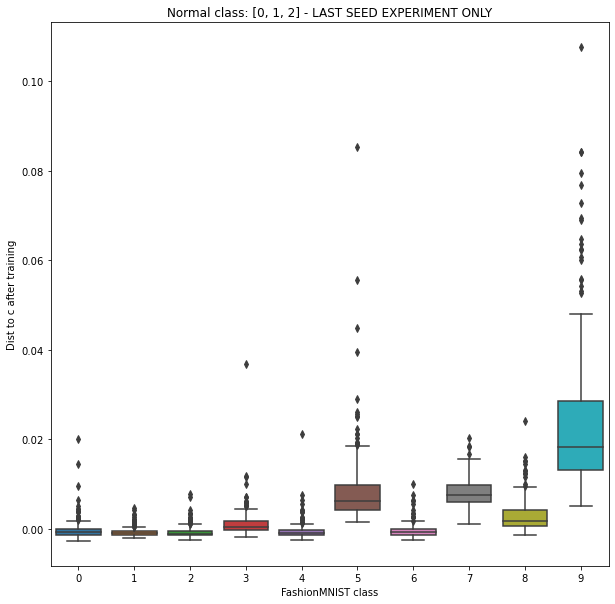

In [6]:
plt.figure(figsize=(10, 10))
boxplot(y=scores_test, x=scores_labels_test)
plt.xlabel('{} class'.format(dataset))
plt.ylabel('Dist to c after training') # minimum over all centroids for test samples
plt.title('Normal class: {} - LAST SEED EXPERIMENT ONLY'.format(normal_cls))
plt.show()

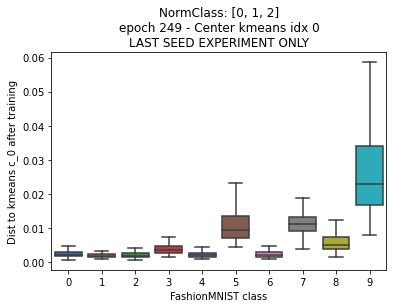

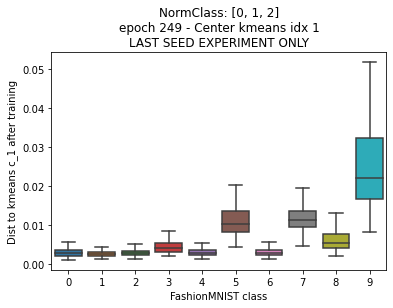

In [7]:
for kmeans_c_idx in range(hyperspheres_center.size()[0]):
    plt.figure()
    boxplot(y=scores_per_center_test[:,kmeans_c_idx].cpu().numpy(), x=scores_labels_test, showfliers=False)
    plt.xlabel('{} class'.format(dataset))
    plt.ylabel('Dist to kmeans c_{} after training'.format(kmeans_c_idx))
    plt.title('NormClass: {}\nepoch {} - Center kmeans idx {}\nLAST SEED EXPERIMENT ONLY'.format(normal_cls, epoch, kmeans_c_idx))

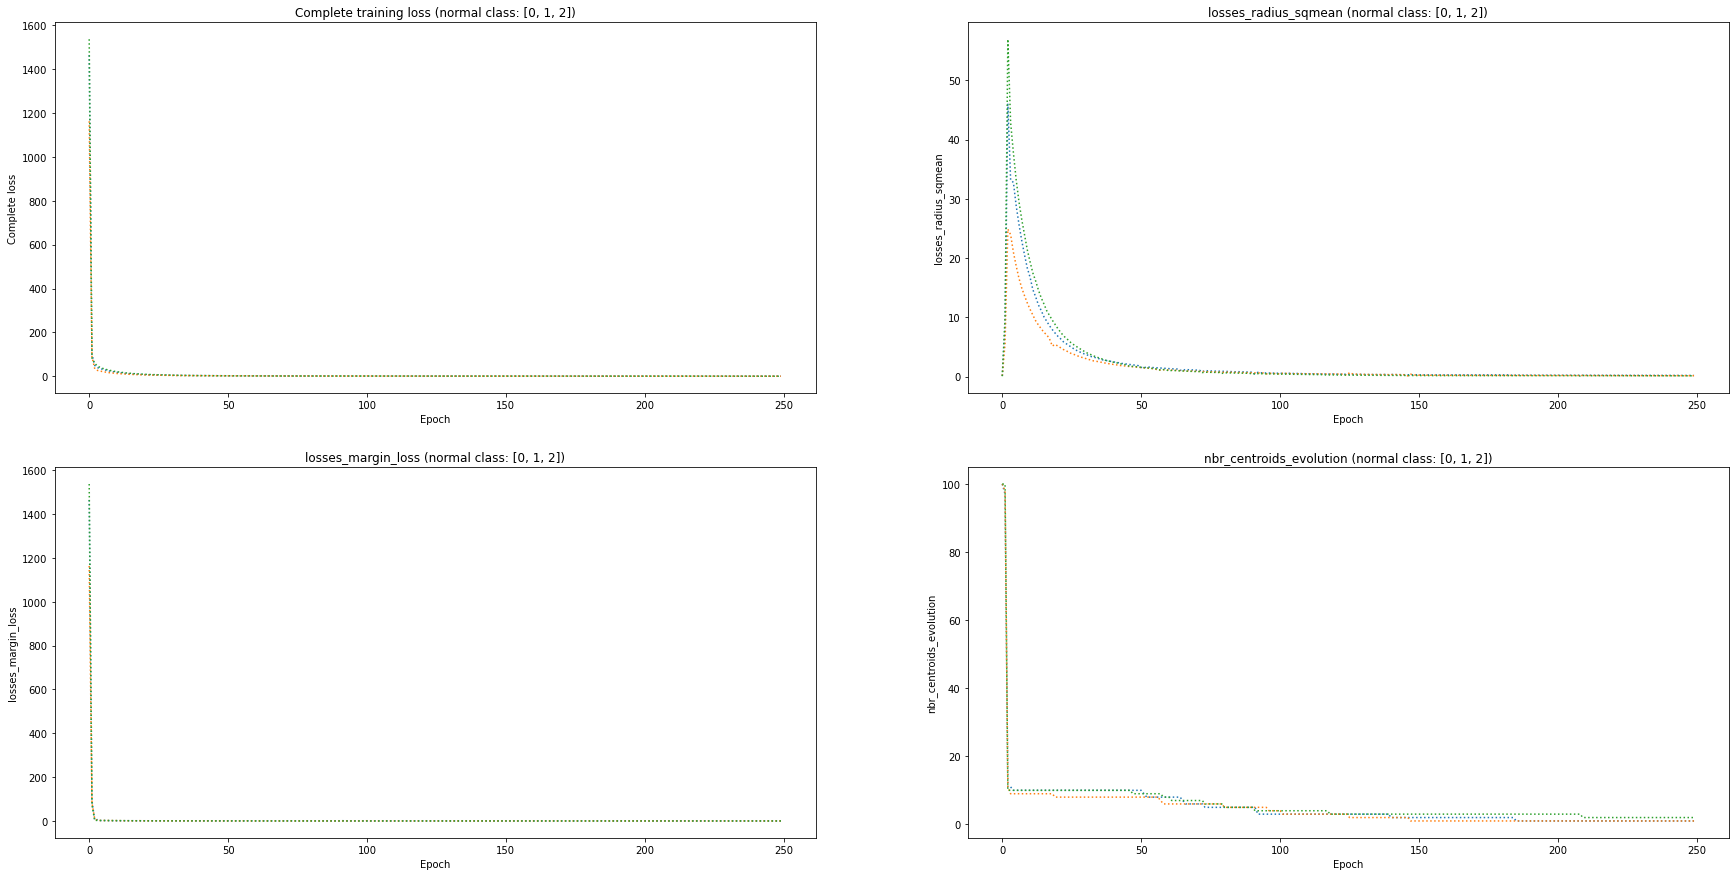

In [8]:
plt.figure(figsize=(30, 15)) 

plt.subplot(2,2,1)
for seed_idx in range(nbr_seeds):
    plt.plot(range(nbr_epochs), losses[seed_idx,:], linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('Complete loss')
    plt.title('Complete training loss (normal class: {})'.format(normal_cls))
    
plt.subplot(2,2,2)
for seed_idx in range(nbr_seeds):
    plt.plot(range(nbr_epochs), losses_radius_sqmean[seed_idx,:], linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('losses_radius_sqmean')
    plt.title('losses_radius_sqmean (normal class: {})'.format(normal_cls))
    
plt.subplot(2,2,3)
for seed_idx in range(nbr_seeds):
    plt.plot(range(nbr_epochs), losses_margin_loss[seed_idx,:], linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('losses_margin_loss')
    plt.title('losses_margin_loss (normal class: {})'.format(normal_cls))
    
plt.subplot(2,2,4)
for seed_idx in range(nbr_seeds):
    plt.plot(range(nbr_epochs), nbr_centroids_evolution[seed_idx,:], linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('nbr_centroids_evolution')
    plt.title('nbr_centroids_evolution (normal class: {})'.format(normal_cls))

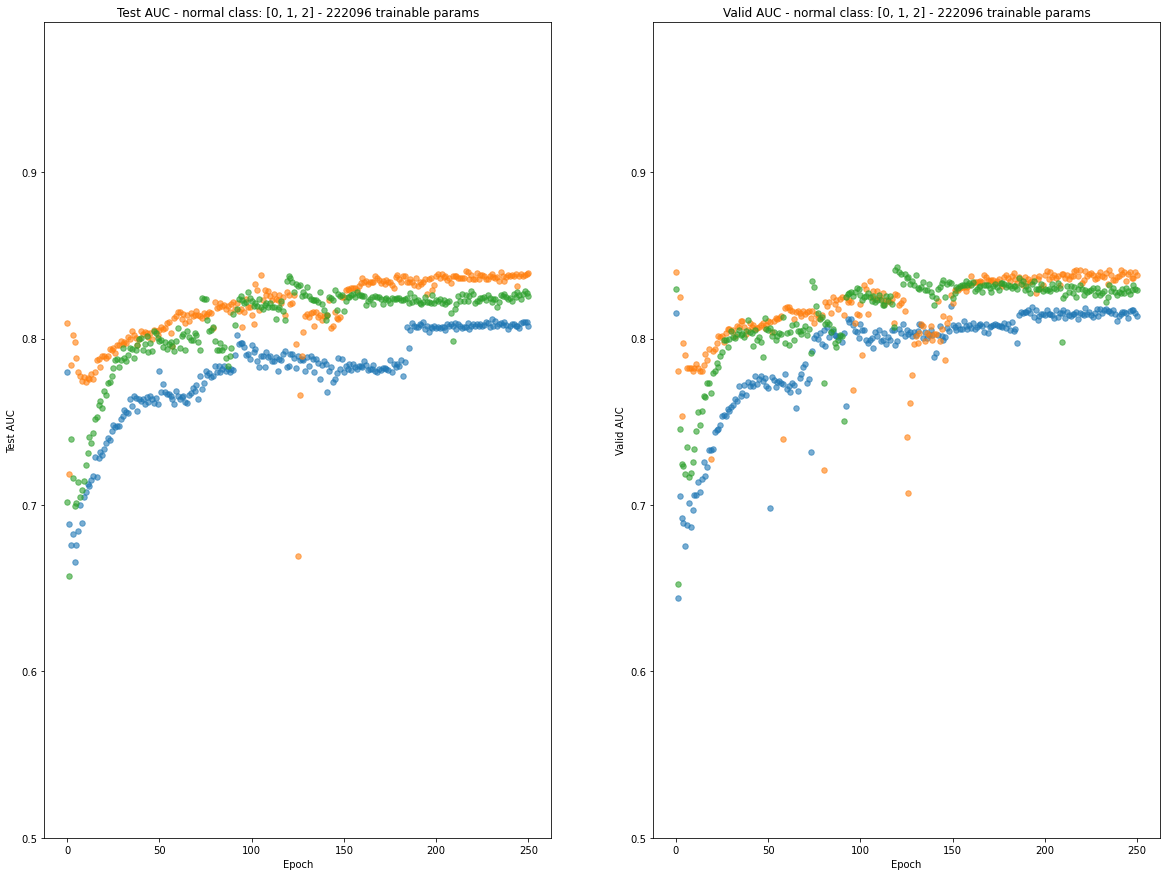

In [9]:
plt.figure(figsize=(20, 15)) 

plt.subplot(1,2,1)
for seed_idx in range(nbr_seeds):
    plt.scatter(range(0, nbr_epochs+1), test_AUCs[seed_idx,:], alpha=0.6, s=30)
    plt.ylim(0.5,0.99)
    plt.xlabel('Epoch')
    plt.ylabel('Test AUC')
    plt.title('Test AUC - normal class: {} - {} trainable params'.format(normal_cls, pytorch_total_params))
    
plt.subplot(1,2,2)
for seed_idx in range(nbr_seeds):
    plt.scatter(range(0, nbr_epochs+1), valid_AUCs[seed_idx,:], alpha=0.6, s=30)
    plt.ylim(0.5,0.99)
    plt.xlabel('Epoch')
    plt.ylabel('Valid AUC')
    plt.title('Valid AUC - normal class: {} - {} trainable params'.format(normal_cls, pytorch_total_params))

In [10]:
test_AUC_at_best_valid = torch.gather(test_AUCs,1,torch.max(valid_AUCs, dim=1)[1].long().unsqueeze(1))
test_AUC_at_best_test = torch.gather(test_AUCs,1,torch.max(test_AUCs, dim=1)[1].long().unsqueeze(1))
print("MEAN TEST AUC +/- STD: {} +/- {}".format(torch.mean(test_AUC_at_best_valid),torch.std(test_AUC_at_best_valid)))

MEAN TEST AUC +/- STD: 0.8211885094642639 +/- 0.02888326160609722


In [11]:
with open('last_results.txt', "a") as file:
    file.write("DeepMSVDD-{}-Norm{}-BSize{}-LR{}-{}epochs-{}seeds-Pretr{} - MEAN TEST AUC (best valid epoch) +/- STD: {} +/- {} | MEAN TEST AUC (best test epoch) +/- STD: {} +/- {}\n".format(dataset, normal_cls, batch_size, learning_rate, nbr_epochs, nbr_seeds, use_pretraining, torch.mean(test_AUC_at_best_valid),torch.std(test_AUC_at_best_valid),torch.mean(test_AUC_at_best_test),torch.std(test_AUC_at_best_test)))